In [75]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

folder = '../data/prepilot'
filename = 'main_part_pilot_2021-12-09'
plot_folder = '../plots/prepilot'

# folder = '../data/test'
# filename = 'main_part_pilot_2021-11-19.csv'


In [76]:
df = pd.read_csv(os.path.join(folder, f'{filename}.csv'))

max_player = 4

# where = (
#     (df['player.id_in_group'] >= 2) & 
#     (df['player.id_in_group'] <= max_player + 1)
# )

where = (
    ~df['player.contribution'].isnull()
)

df = df[where]


def get_punishment(row):
    member_idx = row['player.role'][-1]
    return row[f"group.punishment{member_idx}"]

columns = ['session.code', 'group.id_in_subsession', 'subsession.round_number', 'episode', 'participant.code','player.contribution', 'player.no_input', 'player.punishment', 'group.no_input_manager', 'group.total_contribution', 'group.common_good', 'group.total_punishment']

df['episode'] = df['subsession.round_number'] // 8

df['player.punishment'] = df.apply(get_punishment, axis=1)
df = df[columns]


In [77]:
df.head()

,session.code,group.id_in_subsession,subsession.round_number,episode,participant.code,player.contribution,player.no_input,player.punishment,group.no_input_manager,group.total_contribution,group.common_good,group.total_punishment
0,sdvfxj22,3,1,0,aabz5uo1,20.0,0,5.0,0,70.0,96.0,10.0
1,sdvfxj22,3,1,0,l17vuues,20.0,0,5.0,0,70.0,96.0,10.0
3,sdvfxj22,2,1,0,1jyxixt1,10.0,0,5.0,0,45.0,40.0,20.0
7,sdvfxj22,5,1,0,4btjlc6x,20.0,0,0.0,0,50.0,80.0,0.0
8,sdvfxj22,4,1,0,f4d3x0gh,10.0,0,0.0,0,60.0,96.0,0.0


In [78]:
groupby = ['session.code', 'group.id_in_subsession', 'subsession.round_number']

# check total_contribution
check = df.groupby(groupby)['group.total_contribution'].first() == df.groupby(groupby)['player.contribution'].sum()
assert check.all(), 'Sum of total contributions does not match group contribution.'
check = df.groupby(groupby)['group.total_contribution'].count()
assert check.nunique() == 1, 'There are different number of data points per round'
check = df.groupby(groupby[:-1])['group.total_contribution'].count()
assert check.nunique() == 1, 'There are different number of data points per group'

df['player.contribution.sum'] = df.groupby(groupby)['player.contribution'].transform('sum')
# df['player.punishment.sum'] = df.groupby(groupby)['player.punishment'].transform('sum')
# df['group.total_contribution.sum'] = df.groupby(groupby)['group.total_contribution'].transform('sum')
# df['group.total_punishment.sum'] = df.groupby(groupby)['group.total_punishment'].transform('sum')

# df.set_index(groupby).loc[~check, ['group.total_contribution', 'player.contribution', 'player.contribution.sum']]


In [79]:
df.to_csv(os.path.join(folder, f'{filename}_player_round.csv'))

<Figure size 1008x720 with 0 Axes>

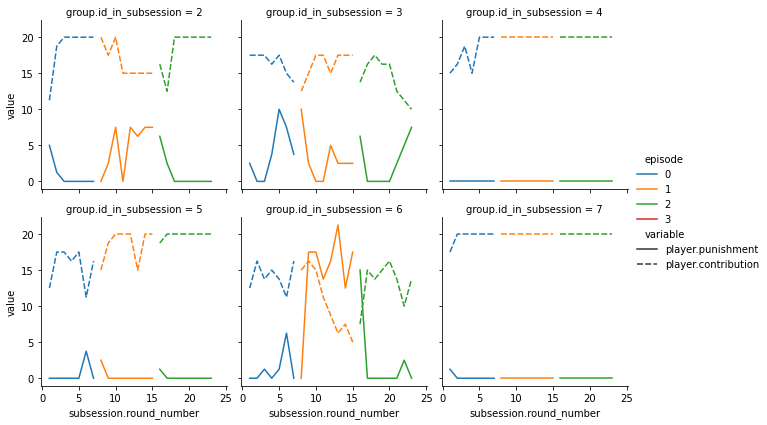

In [80]:
plt.figure(figsize=(14,10))

dfm = df.melt(id_vars=['group.id_in_subsession', 'subsession.round_number', 'participant.code', 'episode'], value_vars=['player.punishment', 'player.contribution'])

dfm['episode'] = dfm['episode'].astype(str)

g = sns.relplot(
    data=dfm,
    x="subsession.round_number", y="value", col='group.id_in_subsession', hue='episode',
    style='variable',
    kind="line", ci=None,
    col_wrap=3, height=3, aspect=1,

)
plt.savefig(os.path.join(plot_folder, 'temporal.png'), dpi=300)

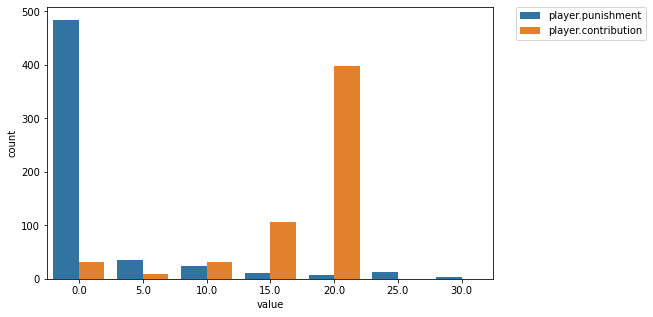

In [84]:
plt.figure(figsize=(8,5))

sns.countplot(x="value", hue="variable", data=dfm, )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(plot_folder, 'contribution_punishments.png'), dpi=300)

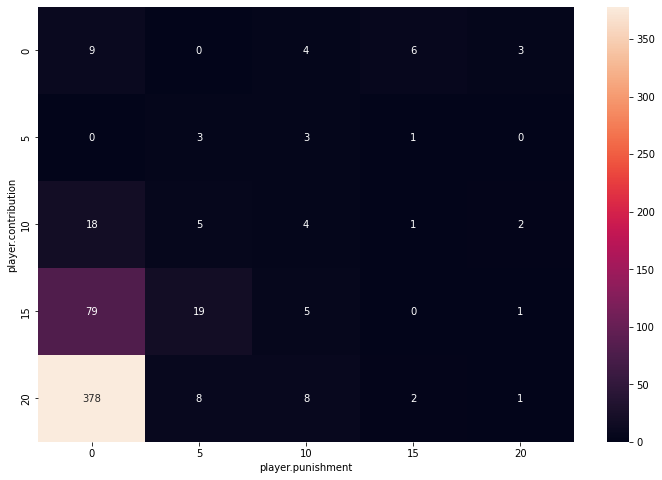

In [85]:
plt.figure(figsize=(12,8))
pt = df.pivot_table(index='player.contribution', columns='player.punishment', values='participant.code', aggfunc='count')
pt = pt.reindex(columns=range(0,25,5), index=range(0,25,5)).fillna(0).astype(int)
sns.heatmap(pt, annot=True, fmt='d')
plt.savefig(os.path.join(plot_folder, 'contribution_punishments_matrix.png'), dpi=300)